In [1]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from numba import njit, prange
from Bloom import *
from Hpoly import *
import numpy as np


N = 1 << 16
MAX_LENGTH = 100        # по факту 2*t з методички

In [7]:
@njit(parallel=True)
def run_experiment_fast(alpha: float, s: int, trials: int = 10) -> float:
    """Експеримент з фільтром Блума"""
    n = int(alpha * N)
    error_rates = np.zeros(trials)
    
    for trial in prange(trials):
        # Ініціалізація фільтра
        keys = np.random.randint(1, N, s)
        T = np.zeros(N, dtype=np.bool_)
        stored_hashes = np.zeros(n, dtype=np.uint64)
        
        # Додавання елементів
        for i in range(n):
            length = np.random.randint(1, MAX_LENGTH + 1)
            s_chars = np.random.randint(97, 123, length).astype(np.uint8)
            data = preprocess_data(s_chars)
            
            # Збереження хешу
            str_hash = np.uint64(0)
            for byte in data:
                str_hash = (str_hash << 8) | byte
            stored_hashes[i] = str_hash
            
            bloom_add(T, keys, data)
        
        # Перевірка хибних спрацювань
        M = 1
        while M < 10**6:
            length = np.random.randint(1, MAX_LENGTH + 1)
            test_chars = np.random.randint(97, 123, length).astype(np.uint8)
            test_data = preprocess_data(test_chars)
            
            # Перевірка через фільтр
            found = bloom_contains(T, keys, test_data)
            
            # Перевірка на false positive
            test_hash = np.uint64(0)
            for byte in test_data:
                test_hash = (test_hash << 8) | byte
            
            if found and (test_hash not in stored_hashes):
                break
            M += 1
        
        error_rates[trial] = 1 / M
    
    return np.mean(error_rates)

def run_parallel():
    """Паралельний запуск експериментів"""
    alpha_values = np.arange(0.05, 0.51, 0.05)
    s_values = np.arange(2, 12)
    params = [(alpha, s) for alpha in alpha_values for s in s_values]
    
    # Використання 4 процесів
    results = Parallel(n_jobs=4)(
        delayed(run_experiment_fast)(alpha, s, 5) for alpha, s in params
    )
    
    return np.array(results).reshape(len(alpha_values), len(s_values))

In [8]:
res = run_parallel()

In [9]:
alpha_values = np.arange(.05, .51, .05)
s_values = np.arange(2, 12)
print("alpha \\ s", end="\t")
for s in s_values:
    print(f"{s}\t\t", end="")
for line in range(res.shape[0]):
    print(f"\n{alpha_values[line]:.2f}\t\t", end="")
    for raw in range(res[line].shape[0]):
        print(f"{res[line, raw]:.6f}\t", end="")

alpha \ s	2		3		4		5		6		7		8		9		10		11		
0.05		0.020970	0.006628	0.004211	0.000536	0.014817	0.000194	0.000232	0.000350	0.000096	0.000087	
0.10		0.146700	0.078759	0.143486	0.039520	0.114230	0.073913	0.010121	0.031749	0.013579	0.008063	
0.15		0.054631	0.135230	0.117146	0.184103	0.146753	0.343219	0.327202	0.085252	0.321196	0.277925	
0.20		0.367778	0.116515	0.309048	0.334722	0.362452	0.709524	0.416667	0.328571	0.479167	0.282051	
0.25		0.388333	0.127193	0.346667	0.357607	0.263333	0.522222	0.315385	0.650000	0.766667	0.766667	
0.30		0.550000	0.395238	0.480000	0.396667	0.361905	0.533333	0.365000	0.766667	0.750000	1.000000	
0.35		0.420000	0.348571	0.633333	0.706667	0.840000	0.840000	0.800000	0.800000	0.900000	0.800000	
0.40		0.494444	0.516667	0.662222	0.666667	0.640000	0.750000	0.900000	1.000000	1.000000	1.000000	
0.45		0.614286	0.450000	0.700000	0.900000	1.000000	0.850000	0.633333	0.800000	0.850000	1.000000	
0.50		0.433333	0.600000	0.616667	0.850000	0.633333	1.000000	0.866667	1.000000	0.9000

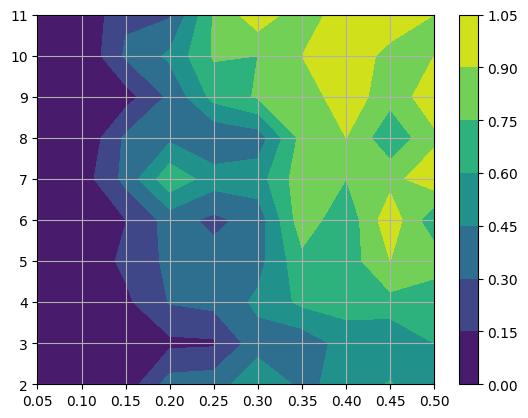

In [10]:
AV, SV = np.meshgrid(alpha_values, s_values)

m = plt.contourf(AV, SV, res.T)
plt.colorbar(m)
plt.grid()

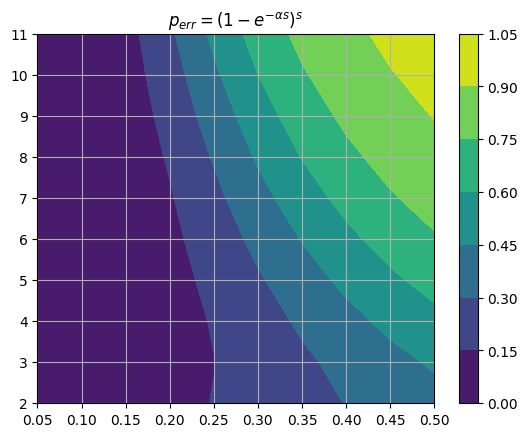

In [11]:
Z = np.pow(1 - np.exp(-AV*SV), SV)

plt.contourf(AV, SV, Z)
plt.title(r"$p_{err}=(1-e^{-\alpha s})^s$")
plt.colorbar()
plt.grid()